# House Prices Prediction

### Introduction

Imagine you’re on a quest to find your dream home. You might think the price depends on bedrooms or a white picket fence. But in reality, home prices are influenced by dozens of factors: the quality of construction, number of bathrooms, neighborhood, and even whether the house has recently been remodeled.

In this notebook, we explore the Ames Housing dataset—where each house tells a story. We’ll explore, engineer, and model to predict house prices, translating features into numbers and numbers into insights. This is more than coding; it’s uncovering the narrative behind every home, understanding what makes a house desirable, and revealing the hidden patterns that drive value.

Through careful preprocessing, feature engineering, and the use of an averaging ensemble of Lasso, Ridge, LightGBM, and XGBoost models, this notebook achieves a RMSLE of 0.11983. This performance ranks 139th out of 4,256 participants on the Kaggle leaderboard, placing it in the top ~3.3% of competitors. The approach demonstrates the power of combining linear trends with complex, non-linear interactions to accurately capture the factors that truly determine house prices.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import warnings
warnings.simplefilter(action='ignore')

%matplotlib inline
sns.set_style('darkgrid')

#### Load data

Every house is a “character,” described by 79 features—from lot size and year built to garage condition. The training set contains SalePrice, the outcome we want to predict, while the test set hides the prices, waiting to be revealed through our model.

In [2]:
train = pd.read_csv("/kaggle/input/dataset/train.csv", index_col='Id')
test = pd.read_csv("/kaggle/input/dataset/test.csv", index_col='Id')

In [3]:
print(train.shape, test.shape)

(1460, 80) (1459, 79)


> 1,460 homes have shared their stories (prices), while 1,459 are waiting for their stories to be uncovered. Each feature tells a part of the narrative of these homes.

In [4]:
# Features & target
X_train = train.drop('SalePrice', axis=1)
y = train['SalePrice']

In [5]:
# Combine for preprocessing
X = pd.concat([X_train, test], axis=0)

In [6]:
catCols = list(X_train.select_dtypes(include=['object']).columns)
print(f"There are {len(catCols)} categorical features:\n", catCols)

There are 43 categorical features:
 ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [7]:
numCols = list(X_train.select_dtypes(include=['int64', 'float64']).columns)
print(f"There are {len(numCols)} numerical features:\n", numCols)

There are 36 numerical features:
 ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


### Exploratory Data Analysis (EDA)

#### Understanding the Target: SalePrice

Let’s begin by exploring the target variable, SalePrice. Its distribution tells the story of the housing market, showing the prevalence of moderately priced homes versus rare, high-end properties.

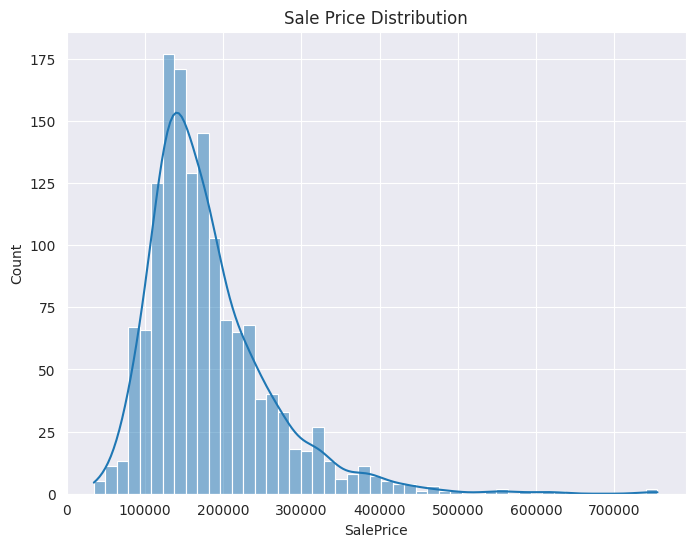

In [8]:
plt.figure(figsize=(8,6))
sns.histplot(y, kde=True)
plt.title('Sale Price Distribution')
plt.show()

In [9]:

print(f"Skewness: {y.skew()}\nKurtosis: {y.kurt()}")

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


The distribution is right-skewed, showing that most homes fall in the moderate price range, while a few luxury properties reach very high prices.

> This tells us that the market is concentrated in mid-range homes, with high-end properties being rare. Later, we will log-transform SalePrice to reduce the impact of extreme values and help models learn more effectively.

#### Numerical Features

We now explore which numerical features are most correlated with SalePrice, revealing the most influential aspects of a home.

In [10]:
num_features = X_train.select_dtypes(include=[np.number])
corr_with_target = num_features.corrwith(y).sort_values(ascending=False)

print("Top 10 numerical features correlated with SalePrice:\n", corr_with_target.head(10))

Top 10 numerical features correlated with SalePrice:
 OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
dtype: float64


Top predictors include `OverallQual`, `GrLivArea`, and `GarageCars/Area`.

> Intuitively, buyers value quality, space, and functional amenities. Larger and higher-quality homes command higher prices, while more garage space adds convenience and perceived value.

We can visualize the relationships:

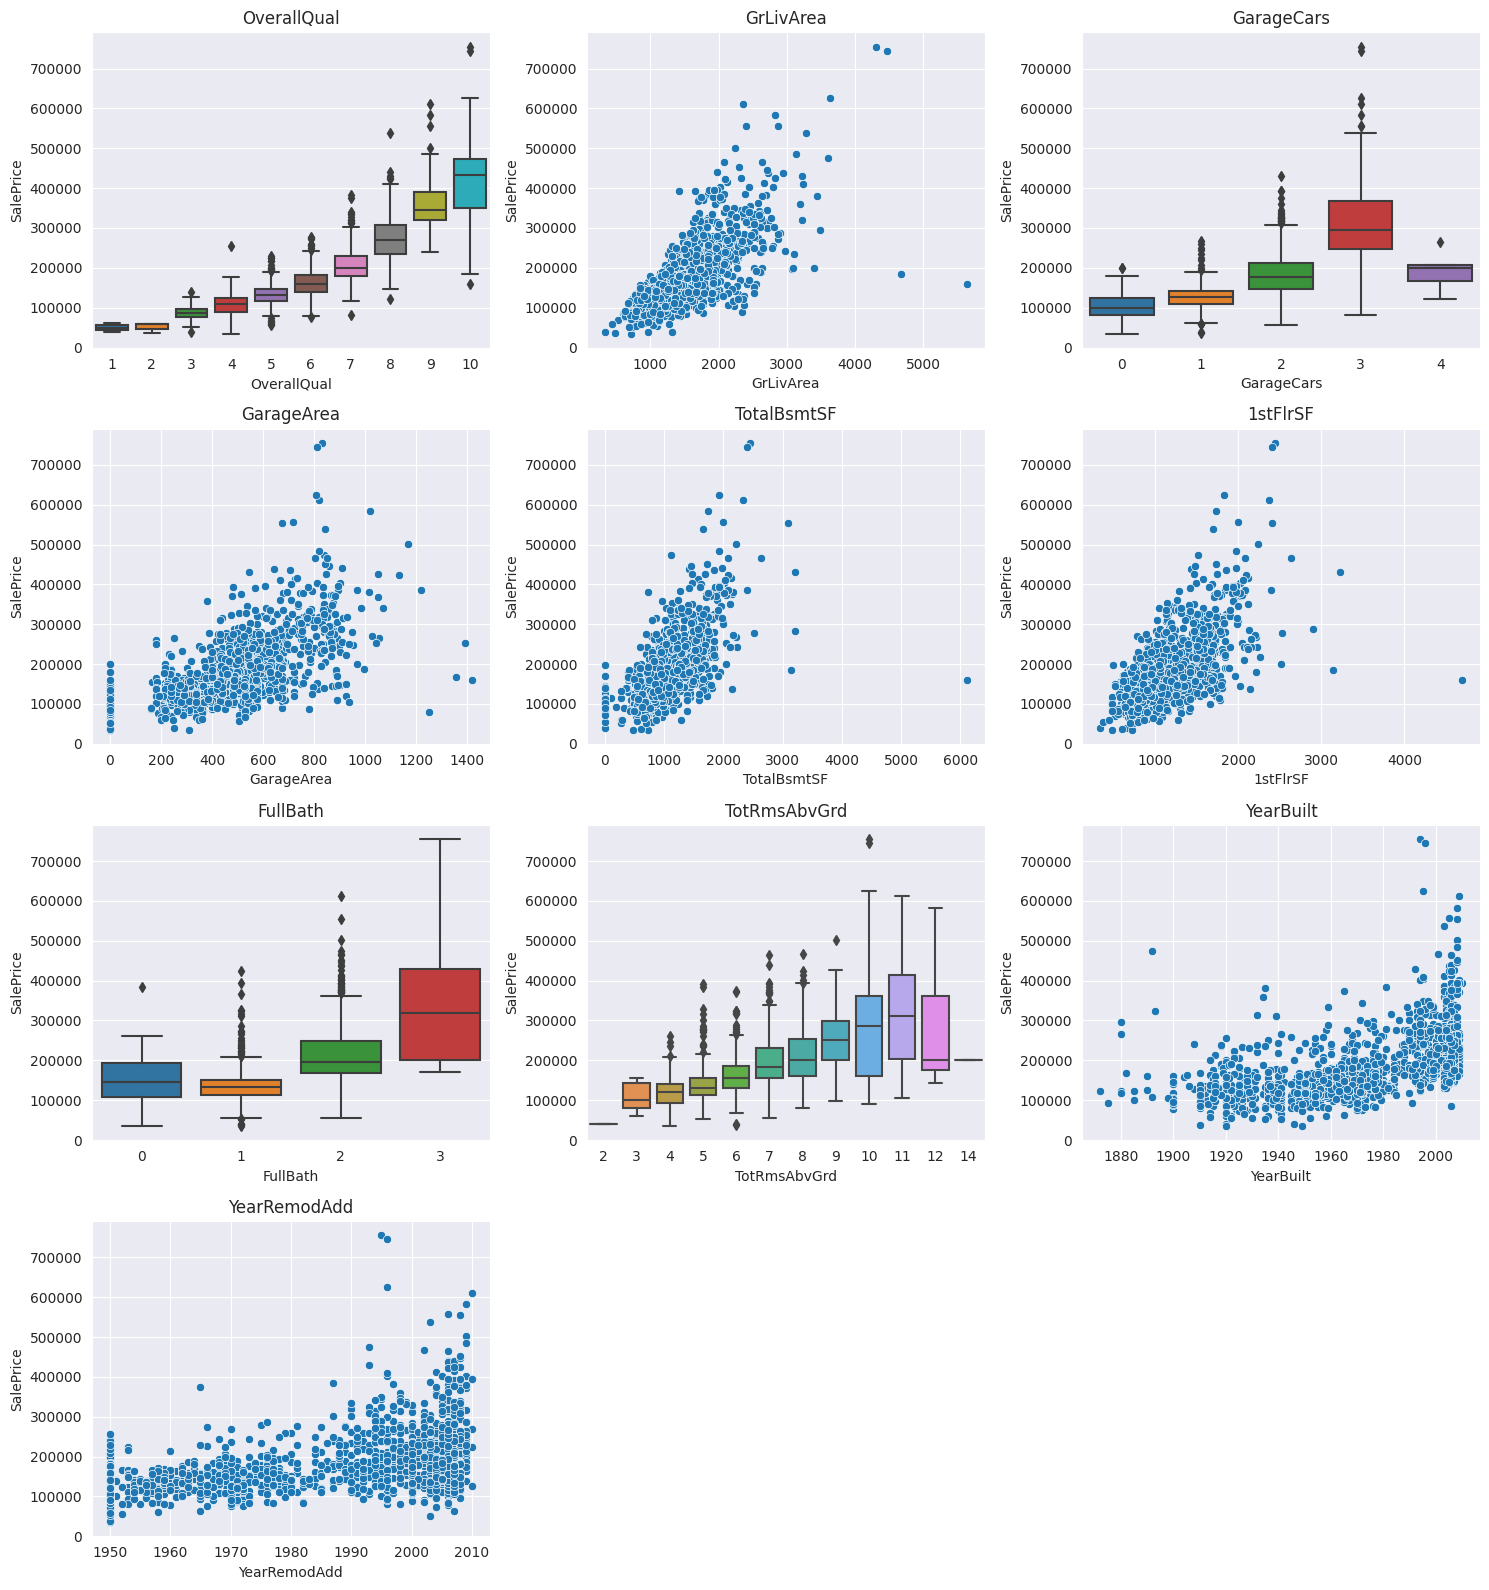

In [11]:
top_num_features = corr_with_target.head(10).index.tolist()

# Grid plot

n_cols = 3
n_rows = math.ceil(len(top_num_features)/n_cols)
plt.figure(figsize=(n_cols*5, n_rows*4))

for i, feature in enumerate(top_num_features):
    plt.subplot(n_rows, n_cols, i+1)
    if X_train[feature].nunique() < 15:
        sns.boxplot(x=X_train[feature], y=y)
    else:
        sns.scatterplot(x=X_train[feature], y=y)
    plt.title(feature)

plt.tight_layout()
plt.show()

> These plots reveal clear trends: higher quality, larger living areas, and more garages correlate with higher prices. Other variables, like total basement area and first-floor size, provide additional insight into usable space.

#### Categorical Features

Numbers alone do not tell the full story. Neighborhood, material quality, and other categorical features can significantly influence home prices.

In [12]:
from sklearn.feature_selection import f_classif

X_cat = X_train[catCols].fillna('None').apply(lambda col: col.astype('category').cat.codes)
F, pval = f_classif(X_cat, y)
sig_cat_features = [catCols[i] for i in range(len(catCols)) if pval[i] < 0.01]
print("Significant categorical features:", sig_cat_features)

Significant categorical features: ['MSZoning', 'Street', 'LotShape', 'LandSlope', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'GarageType', 'GarageFinish', 'GarageQual']


Key features include `Neighborhood`, `ExterQual`, `KitchenQual`, `BsmtQual`, and `GarageFinish`.

In [13]:
def visualize_cat_feature(feature, data=train, target='SalePrice', palette='GnBu_r'):
   
    feat_order = data.groupby(feature)[target].median().sort_values(ascending=False).index
    sns.boxplot(x=feature, y=target, data=data, order=feat_order, palette=palette)
    plt.xticks(rotation=45)
    plt.title(f'{feature} vs {target}')

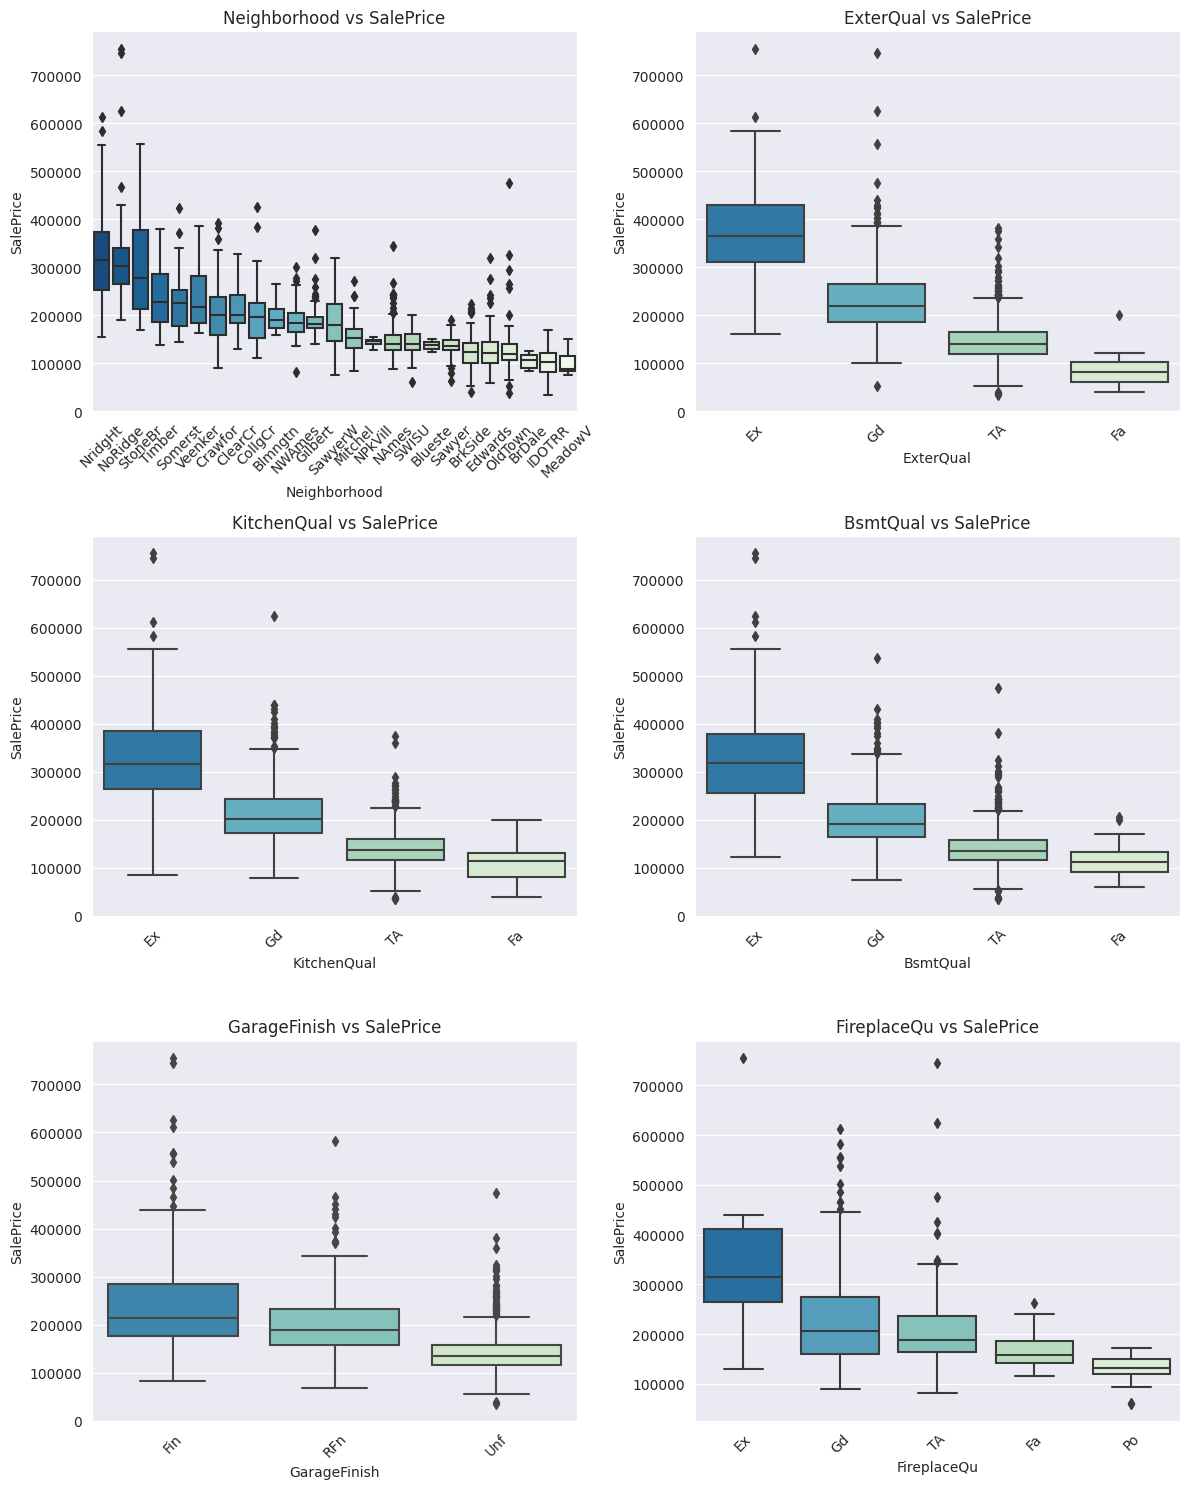

In [14]:
cat_features_important = [
    'Neighborhood', 'ExterQual', 'KitchenQual', 
    'BsmtQual', 'GarageFinish', 'FireplaceQu']

n_cols = 2
n_rows = math.ceil(len(cat_features_important)/n_cols)
plt.figure(figsize=(n_cols*6, n_rows*5))

for i, feature in enumerate(cat_features_important):
    plt.subplot(n_rows, n_cols, i+1)
    visualize_cat_feature(feature)

plt.tight_layout()
plt.show()

Neighborhood is a powerful predictor: homes in desirable areas command higher prices. Quality ratings of the exterior and kitchen, basement, and garage finish also matter because they influence buyers’ perception of comfort, functionality, and luxury.

#### Correlation

Next, we explore correlations between numerical features to understand how home characteristics interact.

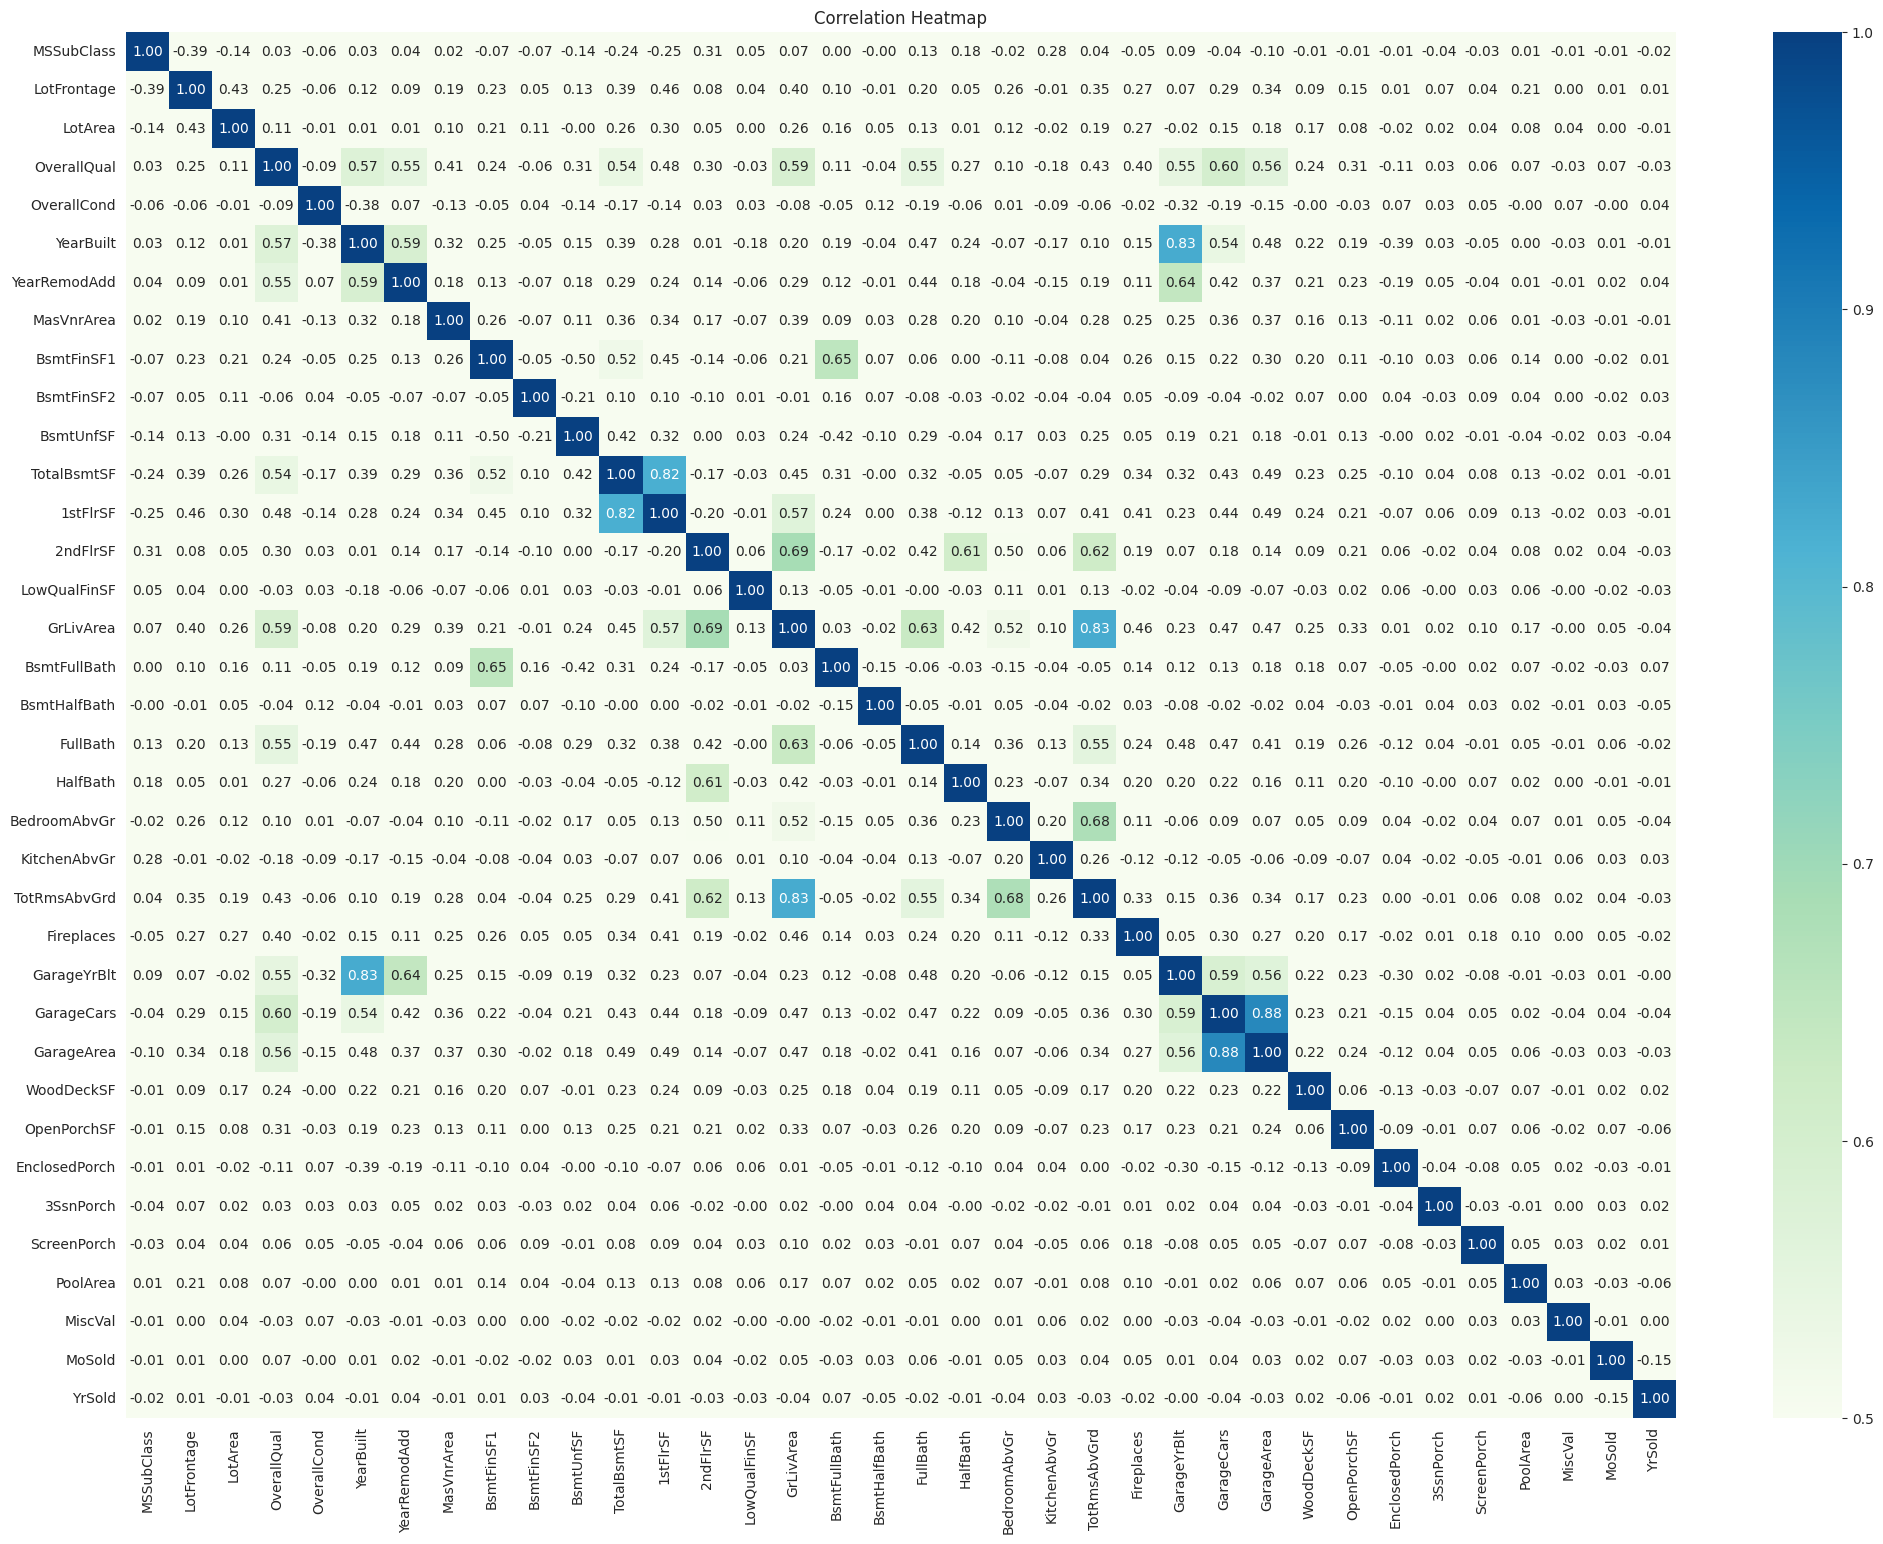

In [15]:
corr_mat = num_features.corr()

# Select features that have an absolute correlation >= 0.5 with other features
high_corr_features = corr_mat.columns[(abs(corr_mat) >= 0.5).any()].tolist()

# Subset the correlation matrix to only those features
high_corr_mat = corr_mat.loc[high_corr_features, high_corr_features]

plt.figure(figsize=(25, 18))
sns.heatmap(high_corr_mat,
            annot=True,
            fmt='.2f',
            cmap='GnBu',
            vmin=0.5,
            vmax=1)
plt.title('Correlation Heatmap')
plt.show()

The heatmap highlights strong pairings: for example, `GarageCars` and `GarageArea` are almost perfectly correlated. Similarly, `1stFlrSF` and `TotalBsmtSF` align closely. Recognizing these redundancies helps prevent multicollinearity in our models.

### Data Preprocessing

Before we build predictive models, we need to prepare the data carefully. Real-world datasets rarely arrive perfectly clean: some features have missing values, some contain outliers, and some are skewed. Cleaning the data ensures our models can learn effectively and make reliable predictions.

#### Missing value

In [16]:
missing_count = X.isnull().sum()
missing_ratio = (missing_count / len(X)) * 100
missing_summary = pd.DataFrame({
    "Missing Count": missing_count,
    "Missing Ratio (%)": missing_ratio
}).query("`Missing Count`>0").sort_values(by="Missing Count", ascending=False)

print(f"Total features with missing values: {missing_summary.shape[0]}")
display(missing_summary.head(5))

Total features with missing values: 34


,Missing Count,Missing Ratio (%)
PoolQC,2909,99.657417
MiscFeature,2814,96.402878
Alley,2721,93.216855
Fence,2348,80.438506
MasVnrType,1766,60.500171


>Many features have missing values, especially those describing rare amenities such as pools, fences, or alleys. This is common in housing datasets—some features simply don’t exist for all houses.

We visualize the top missing features:

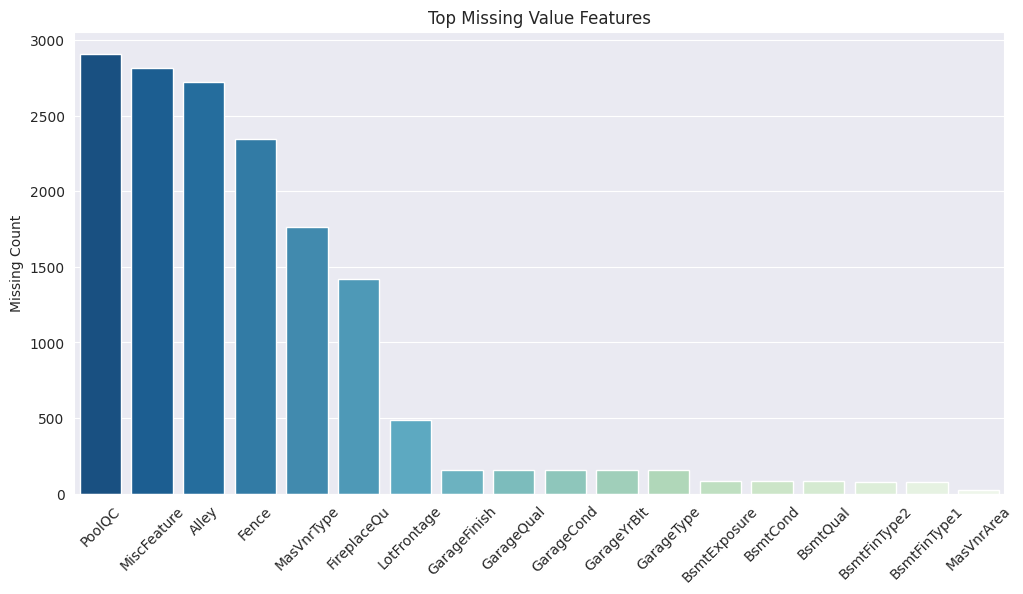

In [17]:
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_summary.head(18).index,y=missing_summary.head(18)["Missing Count"],palette="GnBu_r")
plt.xticks(rotation=45)
plt.title("Top Missing Value Features")
plt.ylabel("Missing Count")
plt.show()

**Cleaning Strategy**

1. Drop features with **>80% missing values**. These provide little information.
2. Fill **categorical NaN values** with `"None"` to indicate absence.
3. Fill **numerical NaN values** with the median to avoid bias from extreme values.
4. Apply domain-specific fixes:
   - `GarageYrBlt` missing values are replaced with `YearBuilt` because garages are usually built with the house.
   - `LotFrontage` is filled with the mean, representing the average street frontage.

In [18]:
# Drop columns with >80% missing
drop_cols = missing_summary[missing_summary["Missing Ratio (%)"] > 80].index
X.drop(columns=drop_cols, inplace=True)

# Fill categorical NaN
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].fillna("None")

# Fill numeric NaN
for col in X.select_dtypes(include=["int64", "float64"]).columns:
    X[col] = X[col].fillna(X[col].median())

# Domain-aware fixes
if 'GarageYrBlt' in X.columns:
    X['GarageYrBlt'] = X['GarageYrBlt'].fillna(X['YearBuilt'])
if 'LotFrontage' in X.columns:
    X['LotFrontage'] = X['LotFrontage'].fillna(X['LotFrontage'].mean())

In [19]:
sum(X.isnull().sum())

0

#### Outliers

Outliers are extreme observations that can distort the model. For example, a house with **4,000+ sq. ft. living area but a very low sale price** is unusual and may represent a data error or an atypical market case.

In [20]:
outliers = train[(train["GrLivArea"] > 4000) & (train["SalePrice"] < 200000)].index 
X.drop(index=outliers, inplace=True) 
y.drop(index=outliers, inplace=True) 

print("Removed outliers:", len(outliers))

Removed outliers: 2


### Feature Engineering

After cleaning, we can **create new features** to capture hidden patterns. Thoughtful feature engineering often has a bigger impact than tweaking model parameters.

In [21]:
X['totalSqFeet'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
X['totalBathroom'] = X.FullBath + X.BsmtFullBath + 0.5 * (X.HalfBath + X.BsmtHalfBath)
X['houseAge'] = X.YrSold - X.YearBuilt
X['reModeled'] = np.where(X.YearRemodAdd == X.YearBuilt, 0, 1)
X['isNew'] = np.where(X.YrSold == X.YearBuilt, 1, 0)

* **totalSqFeet**: the overall living area, a strong predictor of house value.
* **totalBathroom**: combines all bathrooms into a single meaningful measure.
* **houseAge**: accounts for depreciation and buyer preference for newer homes.
* **reModeled**: signals improvements that could raise perceived value.
* **isNew**: distinguishes newly built properties that usually command premium prices.

> These features enrich the dataset with domain knowledge, allowing models to learn more effectively.

#### Label Encoding

Some categorical variables are naturally ordinal or limited in categories, so we convert them to numeric form using **Label Encoding**:

In [22]:
from sklearn.preprocessing import LabelEncoder

label_cols = ["Alley","BsmtExposure","BsmtFinType1","BsmtFinType2","Functional",
              "HeatingQC","LandSlope","LotShape","PavedDrive","PoolQC","Street","Utilities"]

le = LabelEncoder()
for col in label_cols:
    if col in X.columns:
        X[col] = le.fit_transform(X[col])

#### Transform Numerical to Categorical

Some numeric columns are actually **categories represented by numbers**, not continuous values. For instance, `MoSold` refers to the month of sale, `YrSold` to the year, and `MSSubClass` indicates building class. Treating them as numeric would mislead the model, so we cast them into categorical (string) type.

In [23]:
for col in ["YrSold","MoSold","MSSubClass"]:
    if col in X.columns:
        X[col] = X[col].astype(str)

### Skewness and Normalizing Variables

#### Target Variable (SalePrice)

Before modeling, we must check the distribution of the target variable `SalePrice`. Many regression models assume that the target is normally distributed. If it is heavily skewed, the model may perform poorly because extreme values can dominate the learning process.

In [24]:
from scipy import stats
from scipy.stats import norm

def normality_plot(X):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Histogram dengan KDE + kurva normal fit
    sns.histplot(X, kde=True, stat="density", ax=axes[0], color="skyblue")
    mu, sigma = norm.fit(X)
    x = np.linspace(min(X), max(X), 100)
    axes[0].plot(x, norm.pdf(x, mu, sigma), "r--", lw=2)
    axes[0].set_title("Distribution Plot")

    # Q-Q Plot
    stats.probplot(X, dist="norm", plot=axes[1])
    axes[1].set_title("Q-Q Plot")

    plt.tight_layout()
    plt.show()

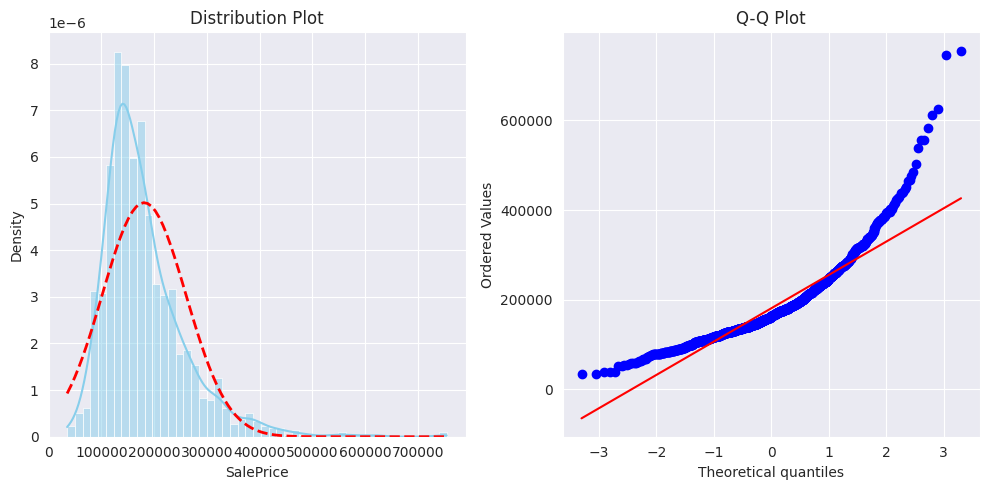

In [25]:
# Before log-transform
normality_plot(y)

The histogram and Q-Q plot below show that `SalePrice` is right-skewed, with many houses sold at lower prices and fewer very expensive houses. To correct this, we apply a log transformation (`log1p`), which makes the distribution closer to normal and reduces the impact of outliers.

In [26]:
# Log1p transform target
y = np.log1p(y)

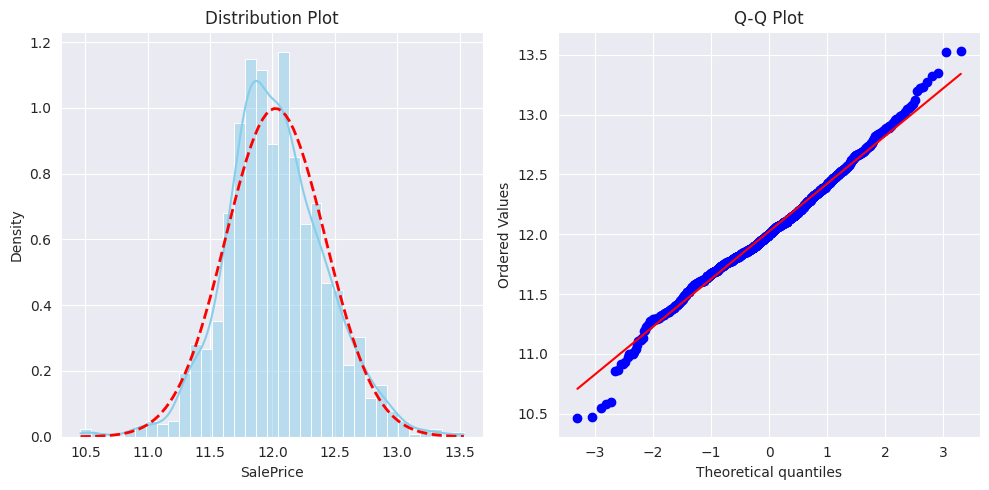

In [27]:
# After log-transform
normality_plot(y)

In [28]:
from scipy.stats import skew

numeric_feats = X.select_dtypes(include=["int64","float64"]).columns
skewness = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_cols = [col for col in skewness[abs(skewness) > 0.5].index if col not in ["SalePrice","MSSubClass"]]

print(f"Skewed features ({len(skewed_cols)}): {skewed_cols[:10]} ...")

Skewed features (37): ['Utilities', 'MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch', 'LandSlope', 'isNew', 'KitchenAbvGr', 'BsmtFinSF2'] ...


Apart from the target variable, many numeric features are also skewed (for example: `LotArea`, `PoolArea`, `MiscVal`). Highly skewed features can reduce the predictive power of models, especially linear ones.

We identify features with absolute skewness > 0.5 and apply a `log1p` transformation to them. This process makes the variables more symmetric and helps the model capture patterns more effectively.


In [29]:
# Log1p transform train
for col in skewed_cols:
    if col in X.columns:
        X[col] = np.log1p(X[col].clip(lower=0))

#### Feature Scaling

In [30]:
from sklearn.preprocessing import RobustScaler

num_cols = X.select_dtypes(include=["int64","float64"]).columns
scaler = RobustScaler()

X[num_cols] = scaler.fit_transform(X[num_cols])

Numeric features often have different ranges (e.g., `GrLivArea` can be in thousands while `OverallQual` is only from 1–10). If left unscaled, models that are sensitive to feature magnitude (like linear regression) may give more weight to features with larger ranges.

To handle this, we apply **RobustScaler**, which scales the data based on the median and interquartile range. This method is less sensitive to outliers than standard scaling, making it suitable for housing price data.


#### One-hot Encoding

Categorical variables need to be converted into numeric format so that models can process them. We use **one-hot encoding** to create binary indicator variables for each category, dropping one level to avoid multicollinearity.

In [31]:
X = pd.get_dummies(X, drop_first=True)

print("X shape after preprocessing:", X.shape)

X shape after preprocessing: (2917, 258)


After encoding, our dataset has **2,917 rows** and **258 features**. This expanded feature space allows the model to capture more detailed patterns from categorical attributes such as neighborhood, building type, and exterior material.

After preprocessing the train and test data, I split them again to perform modeling.

In [32]:
ntest = len(test)
X_train = X.iloc[:-ntest, :]
X_test = X.iloc[-ntest:, :]
print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)

X_train.shape: (1458, 258)
X_test.shape: (1459, 258)


Now we have 1,458 training samples and 1,459 test samples with 258 features each.

### Model Building

After carefully cleaning and transforming the dataset, the next step is to build predictive models. Since house prices are continuous values, this is a regression problem. To capture different aspects of the data, I experimented with both **linear models**, like Ridge and Lasso Regression, and **tree-based models**, such as LightGBM and XGBoost.

Linear models are straightforward and interpretable, helping us understand which features have the strongest influence on house prices. Tree-based models, on the other hand, can naturally capture complex, non-linear interactions, such as how neighborhood, house quality, and total square footage combine to affect the price.

To fairly compare models, I used **cross-validation**, training each model on different subsets of the data multiple times and averaging the results. For evaluation, I chose **Root Mean Squared Logarithmic Error (RMSLE)**, which heavily penalizes large errors—a crucial consideration when predicting high-value homes.

In [33]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def getRMSLE(model):
    """RMSLE cross-validation"""
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error",
                                    cv=kf))
    return rmse.mean()

#### Lasso Regression

**Lasso Regression** is a linear model with an L1 penalty that shrinks less important feature coefficients to zero. This makes it a powerful **feature selection tool** as well as a predictive model.

For predicting house prices, Lasso highlights key drivers like **overall quality** and **total living area** while ignoring less influential features. This leads to a **simpler and interpretable model**.

In [34]:
from sklearn.linear_model import Lasso

lambda_list_lasso = np.linspace(0.0006, 0.0007, 11)
rmsle_lasso_list = [getRMSLE(Lasso(alpha=lmbd, max_iter=100000)) for lmbd in lambda_list_lasso]

best_lambda_lasso = lambda_list_lasso[np.argmin(rmsle_lasso_list)]
lasso = Lasso(alpha=best_lambda_lasso, max_iter=100000)

#### Ridge Regression

**Ridge Regression** is a linear model with an L2 penalty. Unlike Lasso, Ridge does not remove features; instead, it stabilizes coefficients, especially when features are correlated.

For house prices, Ridge ensures that **related features like ground floor area and basement size** are properly balanced, resulting in **smoother and more stable predictions**.

In [35]:
from sklearn.linear_model import Ridge

lambda_list_ridge = np.linspace(20, 25, 101) 
rmsle_ridge_list = [getRMSLE(Ridge(alpha=lmbd)) for lmbd in lambda_list_ridge] 
best_lambda_ridge = lambda_list_ridge[np.argmin(rmsle_ridge_list)] 
ridge = Ridge(alpha=best_lambda_ridge)

#### LightGBM

**LightGBM** is a gradient boosting model built on decision trees. It is fast, memory-efficient, and excellent at capturing **non-linear relationships**.

For house prices, LightGBM can detect patterns such as a **large house in an average neighborhood being valued lower than a smaller house in a premium area**, without requiring extensive feature engineering.

In [36]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(objective='regression', learning_rate=0.05, n_estimators=730, num_leaves=8, min_data_in_leaf=4,
                     max_depth=3, max_bin=255, bagging_fraction=0.78, bagging_freq=5, feature_fraction=0.24,
                     feature_fraction_seed=9, bagging_seed=9, min_sum_hessian_in_leaf=11, verbose=-1, random_state=42)

#### XGBoost

**XGBoost** is a high-performance boosting algorithm. Like LightGBM, it builds an ensemble of trees to iteratively minimize errors. It also offers strong **regularization** to prevent overfitting.

For house price prediction, XGBoost captures complex interactions among features such as **number of rooms, lot size, and garage condition**, producing highly accurate predictions when properly tuned.

In [37]:
from xgboost import XGBRegressor

xgb = XGBRegressor( n_estimators=1000, learning_rate=0.05, max_depth=3, 
                   subsample=0.7, colsample_bytree=0.7, random_state=42, n_jobs=-1 )

### Model Evaluation

Before combining models, it’s important to evaluate each individually. We trained Lasso, Ridge, LightGBM, and XGBoost to understand how well each captures patterns in the housing dataset.

In [38]:
models = [lasso, ridge, lgbm, xgb]

In [39]:
for model in models:
    print(f"{model.__class__.__name__} RMSLE:", getRMSLE(model))

Lasso RMSLE: 0.11337648070545792
Ridge RMSLE: 0.1144096843084845
LGBMRegressor RMSLE: 0.11420362361011546
XGBRegressor RMSLE: 0.1181333773551756


While each model performs reasonably well, no single model can perfectly capture all patterns in the data. Linear models like Lasso and Ridge are excellent at identifying overall trends, whereas tree-based models like LightGBM and XGBoost excel at learning complex, non-linear interactions.

### Averaging Ensemble

Even the best individual model can miss subtle patterns. By averaging predictions from **Lasso, Ridge, LightGBM, and XGBoost**, we create an ensemble that captures **both linear trends and non-linear interactions**.

This simple ensemble reduces bias and variance, often producing more **accurate and robust predictions**.
This approach captures the “wisdom of the models,” balancing linear and non-linear insights from the housing dataset.

In [40]:
from sklearn.base import BaseEstimator, RegressorMixin, clone

class AveragingModels(BaseEstimator, RegressorMixin):
    def __init__(self, models):
        self.models = models
    def fit(self, X, y):
        self.models_ = [clone(m) for m in self.models]
        for model in self.models_:
            model.fit(X, y)
        return self
    def predict(self, X):
        preds = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(preds, axis=1)

averaged_models = AveragingModels(models=models)
print("Averaged Ensemble RMSLE:", getRMSLE(averaged_models))


Averaged Ensemble RMSLE: 0.10997916245191744


Finally, we fit the ensemble to the training data and generate predictions on the test set. The predictions are reversed from log-transformed values back to the original SalePrice scale.

In [41]:
# Fit & Predict
averaged_models.fit(X_train, y)
y_pred = averaged_models.predict(X_test)

# Reverse transform
y_pred_final = np.expm1(y_pred)

In [42]:
submission = pd.DataFrame({'Id': test.index, 'SalePrice': y_pred_final})
submission.head()

,Id,SalePrice
0,1461,120884.473030
1,1462,157957.972897
2,1463,183761.601960
3,1464,198274.167555
4,1465,193165.345090


In [43]:
#submission.to_csv("submission_weighted.csv", index=False)